In [215]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import os
import numpy as np # For potential transform checks
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [216]:
class CraterDetectionDataset(Dataset):
    def __init__(self, json_path, image_dir):
        """
        Initializes the dataset by reading the COCO JSON annotations.
        """
        self.image_dir = image_dir
        # Standard ImageNet normalization values (often used when using ResNet backbones)

        # --- Transformations ---
        # We use standard PyTorch transforms
        transform = T.Compose([
            T.Resize((600, 600)), # Resize all images to a fixed size
            T.ToTensor(), 
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) 
        ])
        self.transform = transform
        
        # Load COCO JSON file
        with open(json_path, 'r') as f:
            coco_data = json.load(f)

        self.images_info = {img['id']: img for img in coco_data['images']}
        self.annotations = coco_data['annotations']
        self.category_id = 1 # Crater category ID [4]

        # Map image IDs to their annotations
        self.img_to_ann = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.img_to_ann:
                self.img_to_ann[img_id] = []
            self.img_to_ann[img_id].append(ann)

        self.image_ids = list(self.images_info.keys())

    def __len__(self):
        """
        Returns the total number of images.
        """
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images_info[img_id]
        file_name = img_info['file_name']
        
        # 1. Load Image
        img_path = os.path.join(self.image_dir, file_name)
        image = Image.open(img_path).convert("RGB")
        
        # --- A. CAPTURE ORIGINAL DIMENSIONS ---
        original_w, original_h = image.size # Width, Height
        
        # Determine Target Size (assuming uniform resize defined in your transform)
        # We assume your transform starts with T.Resize((TARGET_SIZE, TARGET_SIZE))
        TARGET_SIZE = 600 # Assumes T.Resize is the first transform

        # Calculate Scaling Factors
        scale_x = TARGET_SIZE / original_w
        scale_y = TARGET_SIZE / original_h
        # ------------------------------------

        # 2. Extract and Convert Annotations
        annotations = self.img_to_ann.get(img_id, [])
        
        boxes = []
        labels = []
        
        for ann in annotations:
            # COCO format: [x_top_left, y_top_left, width, height]
            x_orig, y_orig, w_orig, h_orig = ann['bbox'] 
            
            # Skip tiny or invalid boxes
            if w_orig <= 0 or h_orig <= 0:
                continue

            # Convert to [x1, y1, x2, y2] format (original absolute coordinates)
            x1_orig = x_orig
            y1_orig = y_orig
            x2_orig = x_orig + w_orig
            y2_orig = y_orig + h_orig
            
            # --- B. APPLY SCALING TO BOX COORDINATES ---
            
            x1_scaled = x1_orig * scale_x
            y1_scaled = y1_orig * scale_y
            x2_scaled = x2_orig * scale_x
            y2_scaled = y2_orig * scale_y

            # Ensure coordinates are integers or properly float-tensed
            boxes.append([x1_scaled, y1_scaled, x2_scaled, y2_scaled])
            labels.append(self.category_id) 
        
        # 3. Assemble RetinaNet Targets List[Dict] format
        if boxes:
            # Convert to float32 tensor as expected by RetinaNet input (retinanet_targets)
            boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32) 
            labels_tensor = torch.as_tensor(labels, dtype=torch.int64)
        else:
            # Handle empty image case
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
            
        target = {
            'boxes': boxes_tensor,
            'labels': labels_tensor
        }

        # 4. Apply Image Transformations (Image resized/normalized, but boxes are already scaled)
        if self.transform:
            image = self.transform(image)
            
        return image, target

In [217]:
# --- Configuration ---
DATA_ROOT = './retina_net_dataset/train' 
JSON_FILE = '_annotations.coco.json' 
IMAGE_DIR = os.path.join(DATA_ROOT)
ANNOTATION_PATH = os.path.join(DATA_ROOT, JSON_FILE)

# --- Instantiate Dataset ---
try:
    crater_dataset = CraterDetectionDataset(
        json_path=ANNOTATION_PATH,
        image_dir=IMAGE_DIR
    )
    print(f"Dataset loaded with {len(crater_dataset)} images.")

except FileNotFoundError as e:
    print(f"Error loading files. Ensure paths are correct: {e}")
except json.JSONDecodeError as e:
    print(f"Error reading JSON file: {e}")


# --- Collation Function ---
# Because object detection targets (List[Dict]) are of variable size, 
# PyTorch DataLoader requires a custom collation function.
def collate_fn(batch):
    # 'batch' is a list of tuples: [(image1, target1), (image2, target2), ...]
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    # Stack images into a single tensor (B, C, H, W)
    images = torch.stack(images, 0)
    
    # Targets remain a list of dictionaries (List[Dict])
    return images, targets

# --- Instantiate DataLoader ---
BATCH_SIZE = 4 

train_dataloader = DataLoader(
    crater_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn, # Use the custom collate function
    # num_workers=4 # Use workers if not running in a simple notebook context
)
print(f"DataLoader ready with batch size {BATCH_SIZE}.")


Dataset loaded with 47 images.
DataLoader ready with batch size 4.


In [218]:
image, targets = crater_dataset[0]

In [219]:
image.shape

torch.Size([3, 600, 600])

In [220]:
targets["boxes"].shape, targets["labels"].shape, targets["labels"].unique()

(torch.Size([103, 4]), torch.Size([103]), tensor([1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9951199].


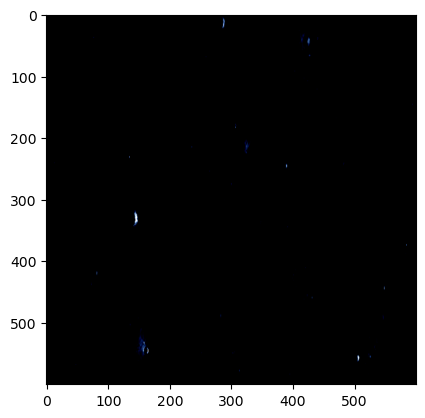

In [221]:
plt.imshow(torch.permute(image, (1, 2, 0)))

In [222]:
def visualize_detection(image_tensor, targets_dict, mean=MEAN, std=STD, class_name="Crater"):
    """
    Denormalizes an image tensor and displays it with ground truth bounding boxes.

    Args:
        image_tensor (torch.Tensor): Normalized image tensor (C, H, W).
        targets_dict (dict): Dictionary containing 'boxes' (N, 4) in [x1, y1, x2, y2]
                             and 'labels' (N,).
        mean (tuple): Mean values used for normalization.
        std (tuple): Standard deviation values used for normalization.
        class_name (str): Name of the detected class (Crater).
    """
    
    # 1. Denormalize and Convert Tensor to NumPy Array (H, W, C)
    
    # Reverse Normalization: value = (normalized_value * std) + mean
    # We use a custom lambda transform to ensure the process is correctly applied channel-wise
    
    denormalize = T.Normalize(
        mean=[-m/s for m, s in zip(mean, std)], 
        std=[1/s for s in std]
    )
    
    img_array = denormalize(image_tensor).cpu().numpy().transpose(1, 2, 0)
    
    # Clamp values to the valid [1] range in case of floating point inaccuracies
    img_array = np.clip(img_array, 0, 1)

    # 2. Extract Bounding Boxes
    # RetinaNet targets use absolute pixel coordinates [x1, y1, x2, y2] [2].
    boxes = targets_dict['boxes'].cpu().numpy()
    labels = targets_dict['labels'].cpu().numpy()
    
    # Get image dimensions (after resizing applied in the dataset)
    H, W, C = img_array.shape

    # 3. Plotting
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_array)
    
    for box, label in zip(boxes, labels):
        # Coordinates are [x1, y1, x2, y2]
        x_min, y_min, x_max, y_max = box
        
        # Calculate width and height for Matplotlib patch
        width = x_max - x_min
        height = y_max - y_min
        
        # Create a Rectangle patch (start point is (x_min, y_min))
        rect = patches.Rectangle(
            (x_min, y_min), 
            width, 
            height,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add label text (Crater, since category_id=1 [3] corresponds to the first class)
        ax.text(
            x_min, y_min - 5, # Position slightly above the box
            f'{class_name} ({label})',
            color='white',
            fontsize=8,
            bbox=dict(facecolor='red', alpha=0.7, edgecolor='none')
        )

    ax.set_title(f"Image Visualization ({len(boxes)} detections)")
    plt.show()

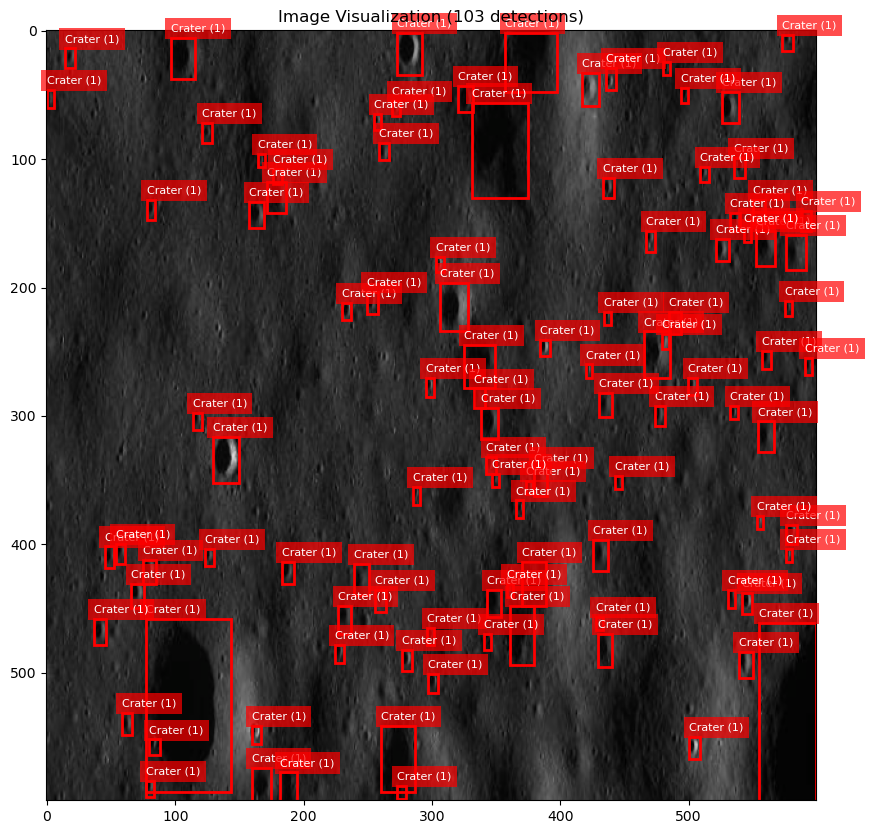

In [223]:
visualize_detection(image, targets)

In [224]:
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"
DEVICE

'cuda'

In [225]:
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights

model = retinanet_resnet50_fpn_v2(
            weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
        ).to(DEVICE)

In [226]:
FINAL_OUTPUT_CLASSES = 1 + 1 # 1 - crater, 1 - background

original_head = model.head.classification_head
num_anchors = original_head.num_anchors # Usually 9

# Determine the input channels to the final classification layer (C=256 in FPN architecture [4, 8])
num_in_channels = original_head.cls_logits.in_channels 

# Re-initialize the final convolutional layer to match the new output size (2 classes * num_anchors)
model.head.classification_head.cls_logits = torch.nn.Conv2d(
    num_in_channels,
    FINAL_OUTPUT_CLASSES * num_anchors, 
    kernel_size=3,
    stride=1,
    padding=1
).to(DEVICE)

prior_prob = 0.01
bias_value = -torch.log(torch.tensor((1 - prior_prob) / prior_prob))
torch.nn.init.constant_(model.head.classification_head.cls_logits.bias, bias_value)
model.head.classification_head.num_classes = FINAL_OUTPUT_CLASSES 

In [227]:
for name, param in model.named_parameters():
    if 'backbone' in name:
        param.requires_grad = False

In [ ]:
NUM_EPOCHS = 10

params_to_optimize = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params_to_optimize, lr=0.01)

model.train() 

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    
    # Dataloader yields (images, targets_list)
    for batch_idx, (images, targets_list) in enumerate(train_dataloader):
        images = images.to(DEVICE)
        
        # Move targets (List[Dict]) to the correct device
        targets_on_device = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets_list]
        
        # 1. Forward Pass: Pass images and targets to the model
        loss_dict = model(images, targets=targets_on_device) 

        # 2. Extract and Sum Losses (L_DET)
        loss_detection_cls = loss_dict['classification'].mean() # Focal Loss
        loss_detection_box = loss_dict['bbox_regression'].mean() # Smooth L1 Loss
        
        # Calculate Total Loss
        loss = loss_detection_cls + loss_detection_box 
        
        total_loss += loss.item()

        # 3. Optimization Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)

    print(f"--- Epoch {epoch+1} finished. Avg Loss: {avg_loss:.4f} ---") 

model.eval()
print("Training Complete")

--- Epoch 1 finished. Avg Loss: 1.5342 ---
--- Epoch 2 finished. Avg Loss: 1.3726 ---
--- Epoch 3 finished. Avg Loss: 1.2441 ---
--- Epoch 4 finished. Avg Loss: 1.1458 ---
--- Epoch 5 finished. Avg Loss: 1.0873 ---
--- Epoch 6 finished. Avg Loss: 1.0420 ---
--- Epoch 7 finished. Avg Loss: 1.0118 ---
--- Epoch 8 finished. Avg Loss: 0.9860 ---
--- Epoch 9 finished. Avg Loss: 0.9660 ---
--- Epoch 10 finished. Avg Loss: 0.9495 ---


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [237]:
output = None
with torch.inference_mode():
    output = model(image.unsqueeze(0).to(DEVICE))
    output = output[0]

In [244]:
output["scores"].mean(), output["scores"].min(), output["scores"].max()

(tensor(0.1806, device='cuda:0'),
 tensor(0.1445, device='cuda:0'),
 tensor(0.3052, device='cuda:0'))

In [248]:
output["boxes"][output["scores"] > 0.2]

tensor([[542.5361, 437.6715, 550.0889, 453.1427],
        [498.5716, 550.2909, 509.5983, 568.2163],
        [ 36.8774, 458.4106,  47.6316, 476.8740],
        [ 78.0227, 127.5881,  91.0208, 146.7784],
        [474.0169, 234.2700, 487.7397, 269.2595],
        [433.1892, 114.9500, 443.0978, 132.9555],
        [274.0565,   0.9857, 292.8234,  30.1845],
        [158.6797, 538.3475, 168.2402, 556.0392],
        [229.1931, 209.2959, 239.8451, 231.2789],
        [129.0402, 315.3965, 152.1462, 350.7136],
        [539.1285, 436.7434, 548.0095, 452.8762],
        [384.8644, 238.5994, 392.7487, 256.3282],
        [131.4067, 225.4292, 140.1017, 244.5451],
        [113.4529, 296.3517, 124.5010, 313.8910],
        [505.1185, 548.1738, 528.1760, 576.4437],
        [526.2542,  48.5709, 537.8356,  71.9520],
        [245.4088,  63.5319, 258.1030,  76.8457],
        [555.4139, 241.8460, 564.5743, 263.9042],
        [259.0645,  85.2496, 268.6074, 104.0151],
        [463.6887, 233.6246, 483.4866, 268.9235],


In [260]:
def get_targets(output, thresh=0.18):
    mask = output["scores"] > thresh
    boxes = output["boxes"][mask]
    labels = output["labels"][mask]
    return {
        "boxes": boxes,
        "labels": labels
    }

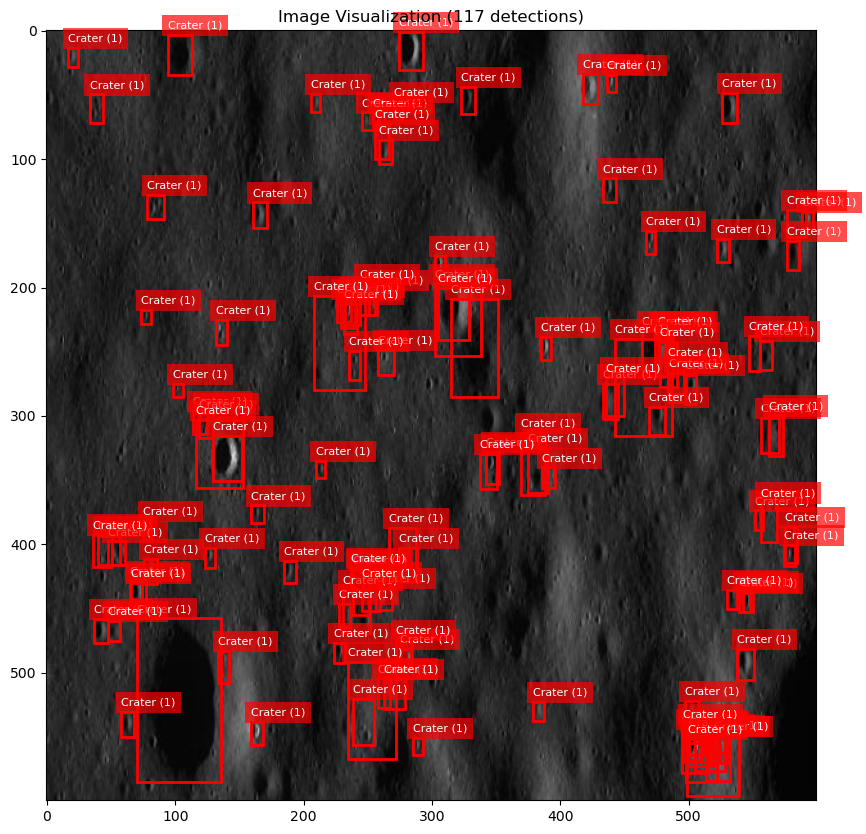

In [261]:
visualize_detection(image, get_targets(output))